In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import utils.functions as functions
from utils.functions import *
import importlib
import json
from utils.graph_repair import repair_network
import matplotlib.patches as patches
import itertools

%load_ext autoreload
%autoreload 2

Please install pyparsing, pydot & graphviz if you want to draw graphs or lattice diagrams


In [2]:
df = pd.read_csv(f"colorings/cons_4_colors_collapsed.txt", sep='\t', header=None)
# unique_permutations = set(itertools.permutations(df.loc[:, 1].values))

In [6]:
df.loc[:, 1].values

array([1, 1, 2, 1, 3, 4, 2, 2, 1, 1, 2, 1, 3, 3, 2, 2, 2, 4, 4, 2, 4, 5,
       6, 7])

In [2]:
input_file = 'PNAS_8worm_dataset_v2.mat'
cmap = get_colormap()

worm_dicts = read_input_mat_file(input_file, remove_trend=True, smooth_spikes=True, mean_zero=True)
    
averaged_results = calculate_metrics(worm_dicts, use_annotations = True, return_average = True)

100%|██████████| 8/8 [00:58<00:00,  7.33s/it]


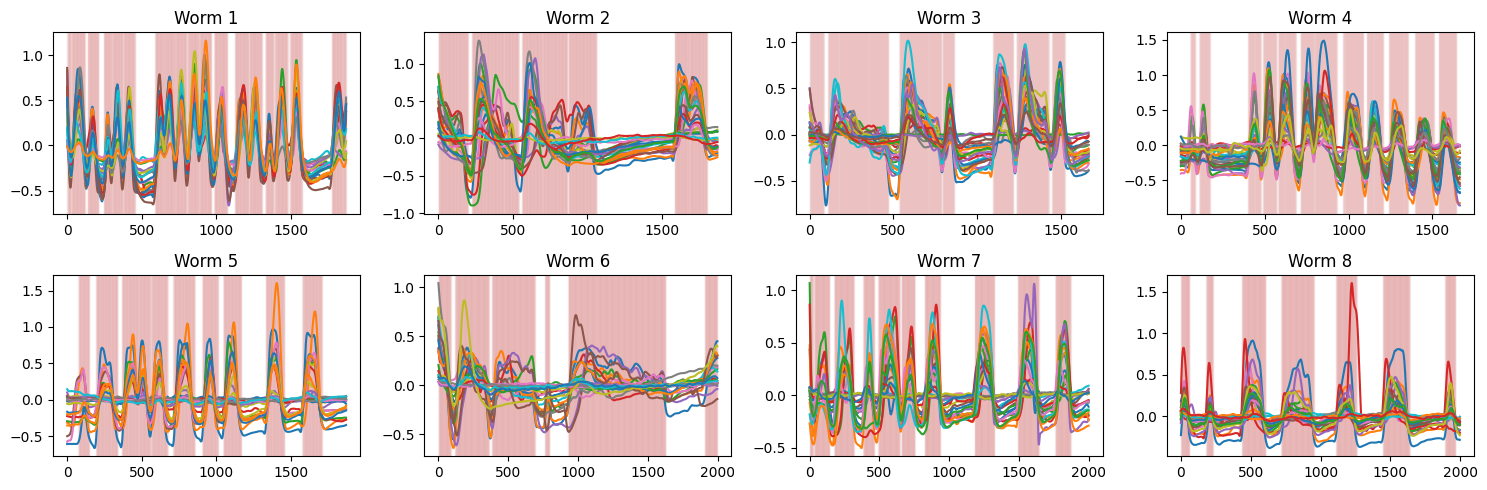

In [3]:
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
ax = ax.flatten()

for i, worm_dict in enumerate(worm_dicts):
    for key, value in worm_dict.items():
        if key == 'annot':
            for idx in range(len(value)):
                if value[idx] > 1:
                    ax[i].axvspan(idx, idx, color='tab:red', alpha=0.03)
        else:
            ax[i].plot(value)
    ax[i].set_title(f'Worm {i+1}')
    
plt.tight_layout()

In [4]:
pairs = list(set(averaged_results.keys()))

## all neurons including AVAR, AVAL, etc
# all_neurons = list(set([item for sublist in pairs for item in sublist]))
# all_neurons.sort()

## to replicate the results in the paper
# all_neurons = ['VA05', 'VA06', 'VA07', 'DA07', 'DA08', 'VA04', 'DA09', 'DA02', 'VA02', 'DA03', 'VA01', 'DA01', 'DA06', 'DA04', 'VA08', 'DA05', 'VA11', 'VA09', 'VA10', 'VA03', 'VA12']
all_neurons = ['DA02', 'VA02', 'VA03', 'DA03', 'DA01', 'DA08', 'DA09', 'VA12', 'VA07', 'VA05', 'VA04', 'VA06', 'DA07', 'VA01', 'VA09', 'VA10', 'VA11', 'DA05', 'DA04', 'VA08', 'DA06']
# all_neurons = ['VA04', 'VA05', 'VA06', 'VA02', 'DA08', 'VA07', 'DA02', 'DA09', 'VA03', 'VA11', 'VA12', 'VA08', 'VA09', 'VA10', 'DA03', 'DA04', 'DA07', 'DA01', 'DA05', 'VA01', 'DA06']

mapping_neuron_to_idx = {all_neurons[idx]:idx for idx in range(len(all_neurons))}
mapping_idx_to_neuron = {idx:all_neurons[idx] for idx in range(len(all_neurons))}

In [5]:
matrices = {}
modified_matrices = {}

for metric in averaged_results[pairs[0]]:
    matrix = np.ones((len(mapping_neuron_to_idx), len(mapping_neuron_to_idx)))
    for pair in pairs:
        if pair[0] in mapping_neuron_to_idx and pair[1] in mapping_neuron_to_idx:
            matrix[mapping_neuron_to_idx[pair[0]], mapping_neuron_to_idx[pair[1]]] = averaged_results[pair][metric]
            matrix[mapping_neuron_to_idx[pair[1]], mapping_neuron_to_idx[pair[0]]] = averaged_results[pair][metric]
    
    threshold = calculate_percolation(matrix)
    modified_matrix = np.where(matrix >= threshold, matrix, 0)
    
    matrices[metric] = matrix
    modified_matrices[metric] = modified_matrix

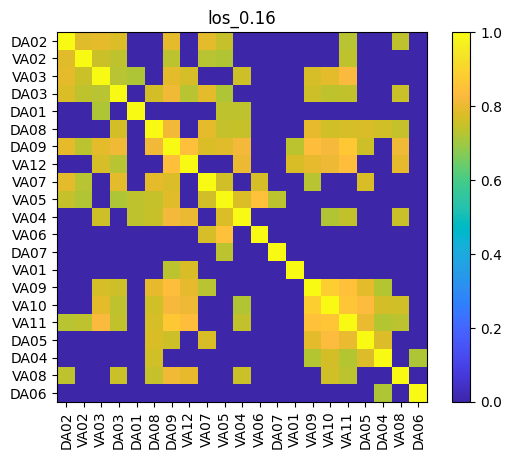

In [6]:
metric = 'los_0.16'
# metric = 'pearson'
plt.imshow(modified_matrices[metric], cmap=cmap, vmin=0, vmax=1)
plt.xticks(range(len(all_neurons)), all_neurons, rotation=90)
plt.yticks(range(len(all_neurons)), all_neurons)
plt.title(metric)
plt.colorbar();

In [13]:
datatable = [['louvain', 'covariance', 'cov'], ['louvain', 'los_0.060000000000000005', 'los_06'],
             ['clique', 'covariance', 'cov'], ['clique', 'los_0.16', 'los_16'], ['clique', 'los_0.17', 'los_17']]

for method, metric, name in tqdm(datatable):
    all_cliques = []

    if method == 'louvain':
        louvain_results = louvain_clustering_best_modularity(modified_matrices[metric], all_neurons, 1000)
        clusters = louvain_results
    if method == 'clique':
        valid_cliques = check_cliques_struc_v2(modified_matrices[metric], all_neurons, 2, 9)
        refined_cliques = refine_cliques(valid_cliques)
        clusters = refined_cliques

    with open(f'colorings/{method[:4]}_{name}_colors_collapsed.txt', 'w') as f:
        for idx, clique in enumerate(clusters):
            for node in clique:
                print(f'{node}\t{idx}', file=f)
                
        print(f'AVE\t{idx+1}', file=f)
        
        print(f'AVD\t{idx+2}', file=f)
        
        print(f'AVA\t{idx+3}', file=f)
        
    with open(f'colorings/{method[:4]}_{name}_colors_uncollapsed.txt', 'w') as f:
        for idx, clique in enumerate(clusters):
            for node in clique:
                print(f'{node}\t{idx}', file=f)
            
        print(f'AVEL\t{idx+1}', file=f)
        print(f'AVER\t{idx+1}', file=f)
        
        print(f'AVDL\t{idx+2}', file=f)
        print(f'AVDR\t{idx+2}', file=f)
        
        print(f'AVAL\t{idx+3}', file=f)
        print(f'AVAR\t{idx+3}', file=f)

100%|██████████| 5/5 [04:27<00:00, 53.48s/it]


In [14]:
collapsed = 'collapsed'
df_weights = pd.read_csv(f'connectomes/{collapsed}_varshney_weights.txt', sep='\t', header=None)
n_shuffle = 1000

res = {}

for run in tqdm(datatable):
    df = pd.read_csv(f"colorings/{run[0][:4]}_{run[2]}_colors_{collapsed}.txt", sep='\t', header=None)
    n_colors = str(df[~df[0].str.startswith('A')][1].max()+1)
    res[run[0]+ '-' + run[2] + '-' + n_colors] = {}
    for a in [1,2]:
        for b in [1,2]:
            
            shuffled_results = []
            for n in range(n_shuffle):
                shuffled_values = np.random.permutation(df.loc[~df[0].str.startswith('A'), 1].values)
                df_copy = df.copy()
                df_copy.loc[~df_copy[0].str.startswith('A'), 1] = shuffled_values
                df_copy.to_csv(f"colorings/temp_shuffle.txt", sep='\t', header=None, index=None)
                EdgesRemoved, EdgesAdded, G_result = repair_network(f"colorings/temp_shuffle.txt", f"connectomes/{collapsed}_varshney.graph.txt", f"outputs/{collapsed}_{run[0][:4]}_{run[2]}_colors_o_", a, b, prohibit_file_path=f"connectomes/{collapsed}_prohibited_edges.txt")
                shuffled_results.append(1.0*(sum([df_weights[(df_weights[0] == edge[0]) & (df_weights[1] == edge[1])][2].values[0] for edge in EdgesRemoved]) + len(EdgesAdded)) / df_weights[2].sum())
            
            EdgesRemoved, EdgesAdded, G_result = repair_network(f"colorings/{run[0][:4]}_{run[2]}_colors_{collapsed}.txt", f"connectomes/{collapsed}_varshney.graph.txt", f"outputs/{collapsed}_{run[0][:4]}_{run[2]}_colors_o_", a, b, prohibit_file_path=f"connectomes/{collapsed}_prohibited_edges.txt")
            # res[run[0]+ '-' + run[2]][(a,b)] = [(len(EdgesRemoved)+len(EdgesAdded))/56.0]
            res[run[0]+ '-' + run[2] + '-' + n_colors][(a,b)] = ((sum([df_weights[(df_weights[0] == edge[0]) & (df_weights[1] == edge[1])][2].values[0] for edge in EdgesRemoved]) + len(EdgesAdded)) / df_weights[2].sum(), 
                                                                 (np.array(shuffled_results) < (sum([df_weights[(df_weights[0] == edge[0]) & (df_weights[1] == edge[1])][2].values[0] for edge in EdgesRemoved]) + len(EdgesAdded)) / df_weights[2].sum()).sum() / n_shuffle)
            # res[run[0]+ '-' + run[2]][(a,b)] = (sum([df_weights[(df_weights[0] == edge[0]) & (df_weights[1] == edge[1])][2].values[0] for edge in EdgesRemoved]) + len(EdgesAdded)) / df_weights.shape[0]
            

created all pairs
connectomes/collapsed_prohibited_edges.txt
Read prohibited edges: 59 prohibited edges
Set parameter WLSAccessID
Set parameter WLSSecret


Set parameter LicenseID to value 2598042
Academic license 2598042 - for non-commercial use only - registered to ah___@gradcenter.cuny.edu
Setup time: 0.31839418411254883
Set parameter MIPGap to value 0.1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD Ryzen 9 7950X 16-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
MIPGap  0.1

Academic license 2598042 - for non-commercial use only - registered to ah___@gradcenter.cuny.edu
Optimize a model with 4776 rows, 3649 columns and 33868 nonzeros
Model fingerprint: 0x455e97a3
Model has 212 simple general constraints
  212 ABS
Variable types: 129 continuous, 3096 integer (3096 binary)
Semi-Variable types: 0 continuous, 424 integer
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+00, 3e+00]


In [30]:
df = pd.read_csv('connectomes/collapsed_varshney_weights.txt', sep='\t', header=None)
df.rename(columns={0: 'source', 1: 'target', 2: 'weight'}, inplace=True)

G_orig = nx.from_pandas_edgelist(df, create_using=nx.DiGraph, edge_attr='weight')
G_orig.add_node('VA07')

colors = pd.read_csv('colorings/cons_11_colors_collapsed.txt', sep='\t', header=None)

for row in colors.iterrows():
    G_orig.nodes[row[1][0]]['color'] = row[1][1]

In [31]:
EdgesRemoved, EdgesAdded, G_result = repair_network(f"colorings/cons_11_colors_collapsed.txt", "connectomes/collapsed_varshney.graph.txt", f"outputs/collapsed_colors_o_", 1, 1, prohibit_file_path="connectomes/collapsed_prohibited_edges.txt")

for row in colors.iterrows():
    G_result.nodes[row[1][0]]['color'] = row[1][1]

In [23]:
res = {}

collapsed = 'uncollapsed'
n_cluster = 4
df_weights = pd.read_csv(f'connectomes/{collapsed}_varshney_weights.txt', sep='\t', header=None)
df = pd.read_csv(f"colorings/cons_{n_cluster}_colors_{collapsed}.txt", sep='\t', header=None)
n_colors = str(df[~df[0].str.startswith('A')][1].max()+1)
res['cons-' + str(n_cluster) + f'-{collapsed}'] = {}

for a in [1]:
    for b in [1]:
        
        EdgesRemoved, EdgesAdded, G_result = repair_network(f"colorings/cons_{str(n_cluster)}_colors_{collapsed}.txt", f"connectomes/{collapsed}_varshney.graph.txt", f"outputs/{collapsed}_consensous_{str(n_cluster)}_colors_o_", a, b, prohibit_file_path=f"connectomes/{collapsed}_prohibited_edges.txt", verbose=False)
        # res[run[0]+ '-' + run[2]][(a,b)] = [(len(EdgesRemoved)+len(EdgesAdded))/56.0]
        repair_percentage = modification_epsilon(EdgesRemoved, EdgesAdded, df_weights, how='edge_weight')
        res['cons-' + str(n_cluster) + f'-{collapsed}'][(a,b)] = repair_percentage
        # res[run[0]+ '-' + run[2]][(a,b)] = (sum([df_weights[(df_weights[0] == edge[0]) & (df_weights[1] == edge[1])][2].values[0] for edge in EdgesRemoved]) + len(EdgesAdded)) / df_weights.shape[0]
        print(a,b,repair_percentage)

1 1 0.1589041095890411


In [33]:
# paper figure positions
pos = {
    'AVD': (0,0),
    'AVE': (1,1),
    'AVA': (-1,-1),
    
    'VA04': (3,2),
    'DA09': (3,1.5),
    'DA08': (3,1),
    'DA07': (3,0.5),
    'VA07': (3,0),
    'VA05': (3,-0.5),
    'VA06': (3,-1),
    
    'VA02': (-1,-2),
    'DA02': (-0.5,-2),
    'DA03': (0,-2),
    'VA01': (0.5,-2),
    
    'DA01': (1,4),
    'DA06': (0,4),
    'VA03': (-1,4),
    'VA12': (-2,4),
    
    'VA11': (-2,3),
    'VA10': (-2,2.5),
    'DA05': (-2,2),
    'VA09': (-2,1.5),
    'VA08': (-2,1),
    'DA04': (-2,0.5),
}

# worm body positions
pos = {
    'VA01': (0,0),
    'VA02': (1,0),
    'VA03': (2,0),
    'VA04': (3,0),
    'VA05': (4,0),
    'VA06': (5,0),
    'VA07': (6,0),
    'VA08': (7,0),
    'VA09': (8,0),
    'VA10': (9,0),
    'VA11': (10,0),
    'VA12': (11,0),
    
    'DA01': (0, 1),
    'DA02': (1, 1),
    'DA03': (2, 1),
    'DA04': (3, 1),
    'DA05': (4, 1),
    'DA06': (5, 1),
    'DA07': (6, 1),
    'DA08': (7, 1),
    'DA09': (8, 1),
    
    'AVA': (1, 0.5),
    'AVE': (2, 0.5),
    'AVD': (3, 0.5),
}

if 'AVAL' in G_orig.nodes():
    pos['AVAL'] = (1, 0.7)
    pos['AVAR'] = (1, 0.3)
    
    pos['AVEL'] = (2, 0.7)
    pos['AVER'] = (2, 0.3)
    
    pos['AVDL'] = (3, 0.7)
    pos['AVDR'] = (3, 0.3)

In [49]:
# # paper's colorings
# G_orig.nodes['VA12']['color'] = 0
# G_orig.nodes['VA03']['color'] = 0

# G_orig.nodes['DA06']['color'] = 1
# G_orig.nodes['DA01']['color'] = 1

# G_orig.nodes['DA08']['color'] = 2
# G_orig.nodes['DA09']['color'] = 2
# G_orig.nodes['VA04']['color'] = 2

# G_orig.nodes['VA02']['color'] = 3
# G_orig.nodes['DA02']['color'] = 3
# G_orig.nodes['DA03']['color'] = 3

# G_orig.nodes['VA11']['color'] = 4
# G_orig.nodes['VA10']['color'] = 4
# G_orig.nodes['DA05']['color'] = 4
# G_orig.nodes['VA09']['color'] = 4
# G_orig.nodes['VA08']['color'] = 4
# G_orig.nodes['DA04']['color'] = 4

# G_orig.nodes['AVD']['color'] = 5

# G_orig.nodes['AVE']['color'] = 6

# G_orig.nodes['AVA']['color'] = 7

# G_orig.nodes['DA07']['color'] = 8
# G_orig.nodes['VA07']['color'] = 8
# G_orig.nodes['VA05']['color'] = 8
# G_orig.nodes['VA06']['color'] = 8

# G_orig.nodes['VA01']['color'] = 9

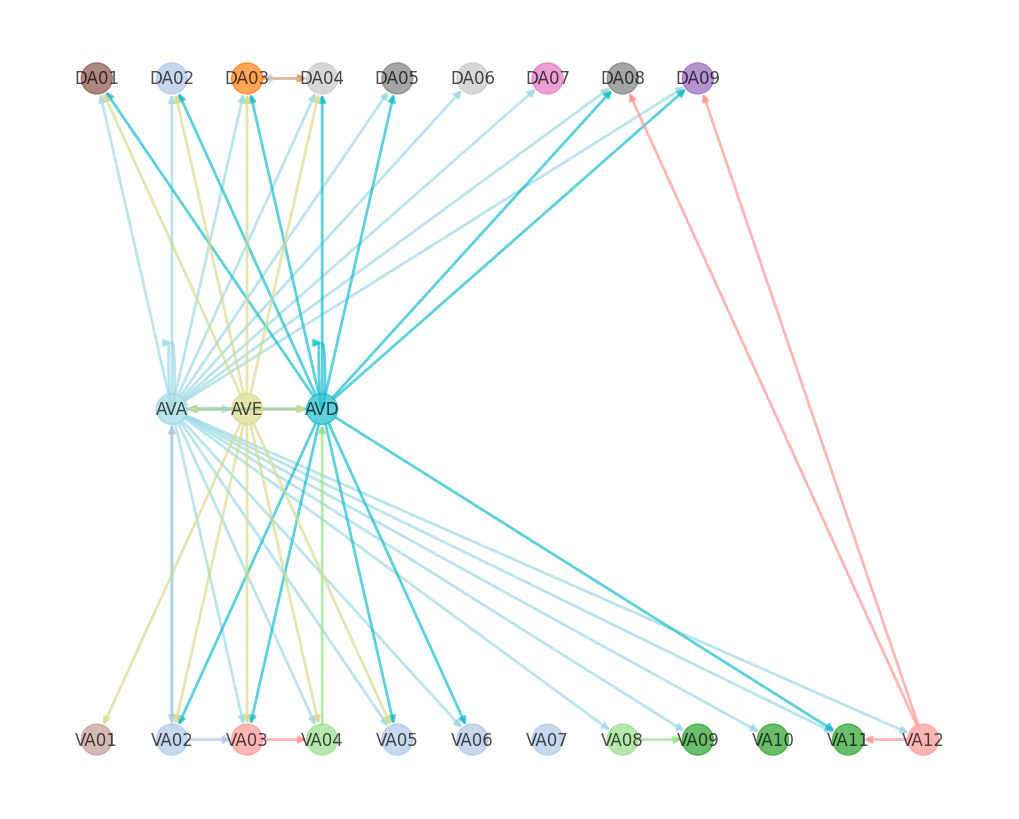

In [34]:
plot_graph_with_weights_and_groups(G_orig, pos=pos, draw_edge_labels=False, uniform_edges=True)

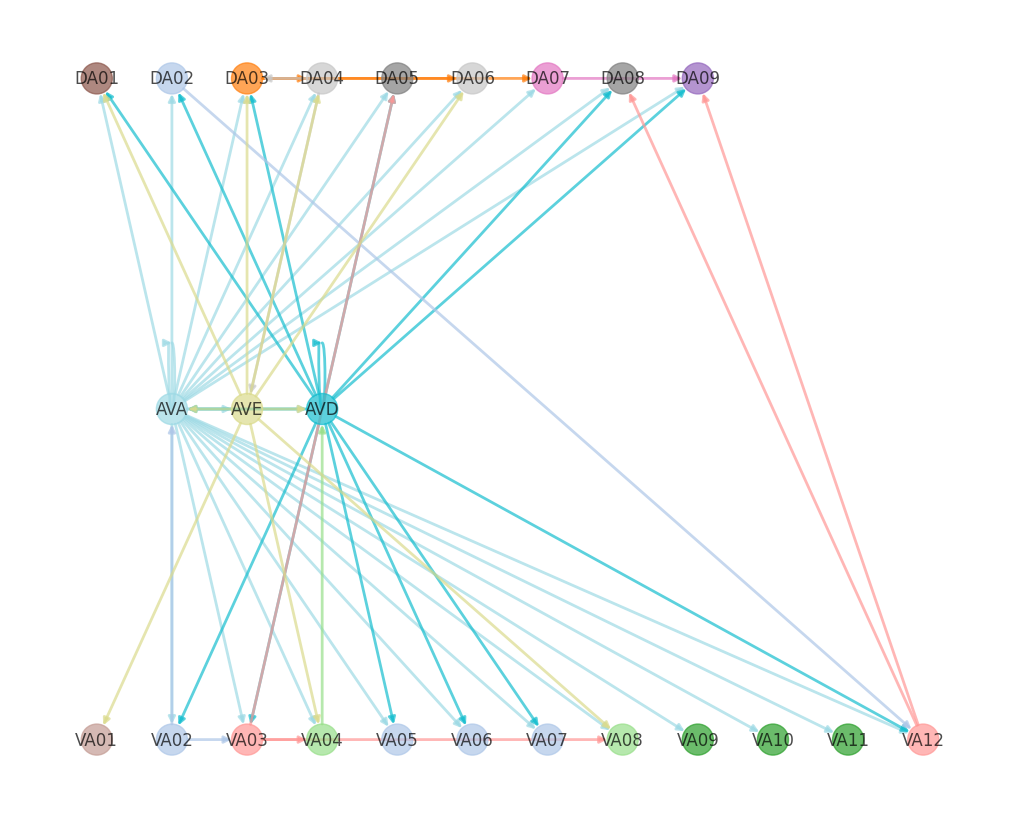

In [35]:
plot_graph_with_weights_and_groups(G_result, pos=pos, draw_edge_labels=False, uniform_edges=True)

In [8]:
try:
    with open('precomputed/all_cliques_detrend_demean_despike.json', 'r') as file:
        # Load the JSON data from the file
        all_cliques = json.load(file)
except:
    all_cliques = []

    for metric, matrix in tqdm(modified_matrices.items(), total=len(modified_matrices)):
        valid_cliques = check_cliques_struc_v2(matrix, all_neurons, 2, 9)
        refined_cliques = refine_cliques(valid_cliques)
        louvain_results = louvain_clustering_best_modularity(matrix, all_neurons, 100)
        
        all_cliques.append(refined_cliques)
        all_cliques.append(louvain_results)
        
    # Convert the list to a JSON string
    json_string = json.dumps(all_cliques)

    # Save the JSON string to a file
    with open("precomputed/all_cliques_detrend_demean_despike.json", "w") as f:
        f.write(json_string)

In [9]:
def create_point_cluster_mapping(clustering_results, columns):
    points = set()
    metric_cluster_mapping = []

    # Collect unique points and map their clusters
    for metric in clustering_results:
        metric_map = {}
        for cluster_id, cluster_points in enumerate(metric):
            for point in cluster_points:
                metric_map[point] = cluster_id
                points.add(point)
        metric_cluster_mapping.append(metric_map)

    # Convert to DataFrame
    points = sorted(points)  # Ensure consistent ordering
    data = []
    for metric_map in metric_cluster_mapping:
        data.append([metric_map.get(point, -1) for point in points])  # -1 if point is not in metric

    return pd.DataFrame(data, index=columns, columns=points).T

In [10]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, jaccard_score

metric_names = [[x[:10]+'_c', x[:10]+'_l'] for x in list(modified_matrices.keys())]
metric_names = sum(metric_names, [])

df = create_point_cluster_mapping(all_cliques, metric_names)
res = np.zeros((len(df.columns), len(df.columns)))

for col1 in enumerate(df.columns):
    for col2 in enumerate(df.columns):
        # res[col1[0], col2[0]] = adjusted_rand_score(df[col1[1]], df[col2[1]])
        res[col1[0], col2[0]] = normalized_mutual_info_score(df[col1[1]], df[col2[1]])
        # res_clique[col1[0], col2[0]] = normalized_mutual_info_score(df_clusters_cliq[col1[1]], df_clusters_cliq[col2[1]]
        # res[col1[0], col2[0]] = jaccard_score(df[col1[1]], df[col2[1]], average='macro')

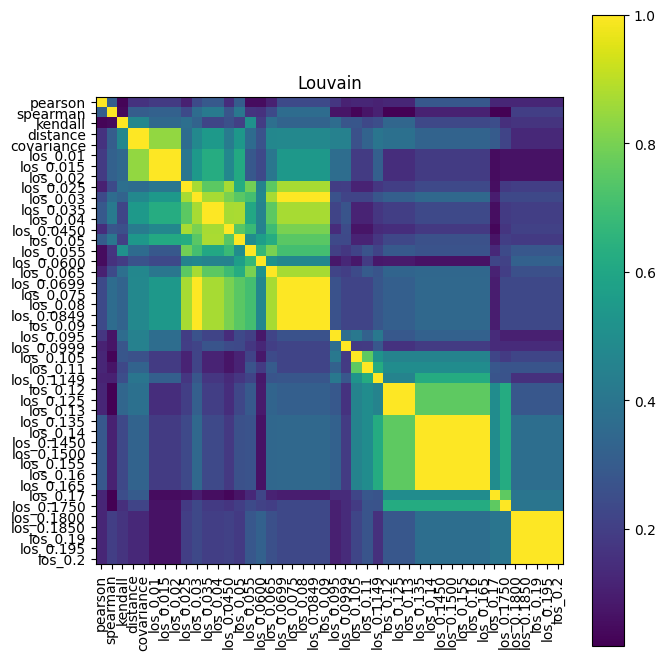

In [11]:
plt.figure(figsize=(7, 7))
# plt.imshow(res[::2, ::2], cmap='viridis')
# plt.title('Clique')
plt.imshow(res[1::2, 1::2], cmap='viridis')
plt.title('Louvain')

plt.xticks(range(44), [x[:-2] for x in metric_names[1::2]], rotation=90)
plt.yticks(range(44), [x[:-2] for x in metric_names[1::2]])
plt.colorbar()

plt.tight_layout()

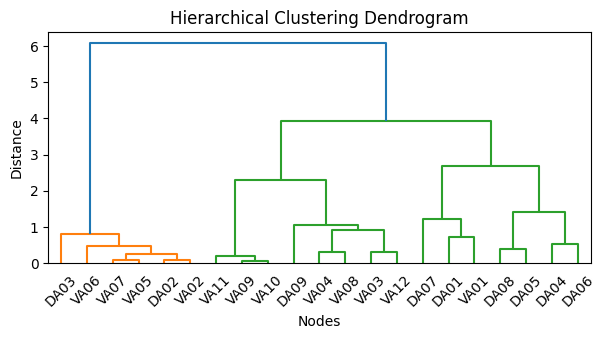

In [12]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

cooccurrence_matrix = get_cooccurrence_matrix(all_cliques, mapping_neuron_to_idx)

# Step 4: Perform Hierarchical Clustering using Ward's Method
linkage_matrix = linkage(cooccurrence_matrix, method='ward')

# Step 5: Plot the Dendrogram
plt.figure(figsize=(7, 3))
dendo = dendrogram(linkage_matrix, labels=all_neurons)
cooccurrence_matrix = cooccurrence_matrix[np.ix_(dendo['leaves'], dendo['leaves'])]
new_node_order = [all_neurons[node] for node in dendo['leaves']]
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Nodes")
plt.ylabel("Distance")
plt.show()

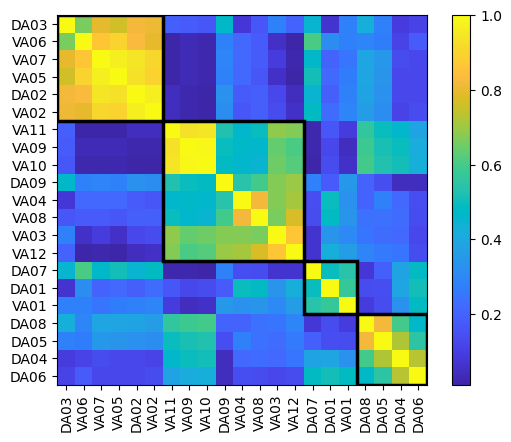

In [22]:
plt.imshow(cooccurrence_matrix, cmap=cmap)
plt.xticks(range(len(new_node_order)), new_node_order, rotation=90)
plt.yticks(range(len(new_node_order)), new_node_order)
plt.colorbar()

squares = [
    [0, 5, 2.5],
    [6, 13, 2.5],
    [14, 16, 2.5],
    [17, 20, 2.5],
]

for start, end, thickness in squares:
    # Add a square (rectangle with equal height and width)
    ax = plt.gca()
    rect = patches.Rectangle(
        (start - 0.5, start - 0.5),  # Rectangle starts slightly offset to align with pixels
        end - start + 1,            # Width
        end - start + 1,            # Height
        linewidth=thickness,                    # Line thickness
        edgecolor='black',                # Line color
        facecolor='none'                # Transparent fill
    )
    ax.add_patch(rect)

In [14]:
for n_cluster in [3,4,5,6,7,8,9,10]:
    clusters = fcluster(linkage_matrix, n_cluster, criterion='maxclust')
    
    with open(f'colorings/cons_{n_cluster}_colors_collapsed.txt', 'w') as f:
        max_id = np.max(clusters)
        for idx, neuron in enumerate(all_neurons):
            print(f'{neuron}\t{clusters[idx]}', file=f)
            
        print(f'AVE\t{max_id+1}', file=f)
        
        print(f'AVD\t{max_id+2}', file=f)
        
        print(f'AVA\t{max_id+3}', file=f)

In [19]:
collapsed = 'collapsed'
df_weights = pd.read_csv(f'connectomes/{collapsed}_varshney_weights.txt', sep='\t', header=None)

res = {}

for idx, i in enumerate([3,4,5,6,7,8,9,10]):
    res[i] = {}
    for a in [1,2]:
        for b in [1,2]:
            EdgesRemoved,EdgesAdded, G_result = repair_network(f"colorings/cons_{i}_colors_collapsed.txt", "connectomes/collapsed_varshney.graph.txt", f"outputs/collapsed_cons_{i}_colors_o_", a, b, prohibit_file_path="connectomes/collapsed_prohibited_edges.txt")
            res[i][(a,b)] = (sum([df_weights[(df_weights[0] == edge[0]) & (df_weights[1] == edge[1])][2].values[0] for edge in EdgesRemoved]) + len(EdgesAdded)) / df_weights[2].sum()

created all pairs
connectomes/collapsed_prohibited_edges.txt
Read prohibited edges: 59 prohibited edges
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2598042
Academic license 2598042 - for non-commercial use only - registered to ah___@gradcenter.cuny.edu
Setup time: 0.13201189041137695
Set parameter MIPGap to value 0.1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0.1

Academic license 2598042 - for non-commercial use only - registered to ah___@gradcenter.cuny.edu
Optimize a model with 4776 rows, 3649 columns and 33870 nonzeros
Model fingerprint: 0x46848163
Model has 212 simple general constraints
  212 ABS
Variable types: 129 continuous, 3096 integer (3096 binary)
Semi-Variable types: 0 continuous, 424 integer
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective ran

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

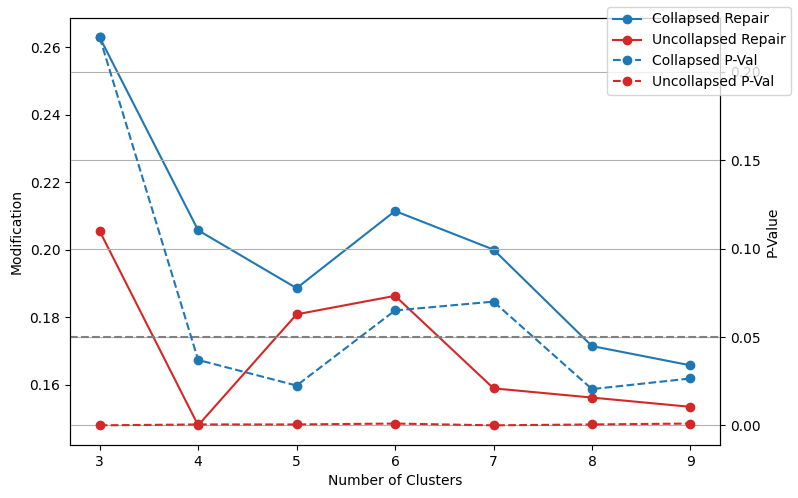

In [9]:
# Plotting
fig, ax1 = plt.subplots(figsize=(8,5))

# Plot the first numbers
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Modification')
ax1.tick_params(axis='y')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('P-Value')

ax2.tick_params(axis='y')
ax2.axhline(y=0.05, color='grey', linestyle='--')


df = pd.read_csv('res_cons_collapsed.csv')
df = pd.DataFrame(df.values.T)

# Combine the first two rows into the headers
new_columns = [
    f"{df.iloc[0, col]}{df.iloc[1, col]}"
    for col in range(df.shape[1])
]

# Assign the new column headers
df.columns = new_columns

# Drop the first two rows and reset the index starting from 3
df = df.iloc[2:].reset_index(drop=True)
df.index += 3
df = df.map(lambda x: eval(x) if isinstance(x, str) and x.startswith('(') and x.endswith(')') else x)

# Find the tuple with the lowest second number in each row
min_values = df.map(lambda x: x if isinstance(x, tuple) else None).apply(
    lambda row: min(row, key=lambda x: x[1] if x else float('inf')), axis=1
)

# Extract the first and second numbers from the tuples
first_numbers = min_values.map(lambda x: x[0])
second_numbers = min_values.map(lambda x: x[1])

ax2.plot(second_numbers.index, second_numbers, '--o', label='Collapsed P-Val', color='tab:blue')
ax1.plot(first_numbers.index, first_numbers, '-o', label='Collapsed Repair', color='tab:blue')


df = pd.read_csv('res_cons_uncollapsed.csv')
df = pd.DataFrame(df.values.T)

# Combine the first two rows into the headers
new_columns = [
    f"{df.iloc[0, col]}{df.iloc[1, col]}"
    for col in range(df.shape[1])
]

# Assign the new column headers
df.columns = new_columns

# Drop the first two rows and reset the index starting from 3
df = df.iloc[2:].reset_index(drop=True)
df.index += 3
df = df.map(lambda x: eval(x) if isinstance(x, str) and x.startswith('(') and x.endswith(')') else x)

# Find the tuple with the lowest second number in each row
min_values = df.map(lambda x: x if isinstance(x, tuple) else None).apply(
    lambda row: min(row, key=lambda x: x[1] if x else float('inf')), axis=1
)

# Extract the first and second numbers from the tuples
first_numbers = min_values.map(lambda x: x[0])
second_numbers = min_values.map(lambda x: x[1])

ax2.plot(second_numbers.index, second_numbers, '--o', label='Uncollapsed P-Val', color='tab:red')
ax1.plot(first_numbers.index, first_numbers, '-o', label='Uncollapsed Repair', color='tab:red')

fig.tight_layout()  # Adjust layout to prevent overlap
plt.grid('on')
fig.legend()
plt.show()